## Classification
### Stroke Prediction Dataset

#### Attribute Information:
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [44]:
import pandas as pd
import numpy as np

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import toad
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import dalex as dx
from mlxtend.feature_selection import SequentialFeatureSelector

In [89]:
df = pd.read_csv(r'C:\Users\HP\Desktop\szkolne\5 rok\ml2\ML2-project\data\c1.csv')

list_dummies = ['ever_married', 'smoking_status', 'Residence_type', 'work_type', 'gender']
df = pd.get_dummies(df, columns=[var for var in list_dummies], drop_first=True)
df.drop(columns = ['id'], inplace=True)

In [47]:
df.columns

Index(['age', 'avg_glucose_level', 'bmi', 'feat01', 'feat02', 'feat03',
       'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09', 'feat10',
       'heart_disease', 'hypertension', 'stroke', 'ever_married_Yes',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'Residence_type_Urban',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'gender_Male',
       'gender_Other'],
      dtype='object')

In [32]:

# plt.figure(figsize=(15, 10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Plot for All Variables')
# plt.show()


feat10                           -0.132068
feat02                           -0.131935
work_type_children               -0.115262
feat05                           -0.031556
work_type_Never_worked           -0.020550
feat09                           -0.020025
feat07                           -0.013926
feat03                           -0.008295
smoking_status_never smoked      -0.005569
gender_Other                     -0.004373
feat04                           -0.001355
smoking_status_smokes             0.012033
gender_Male                       0.012291
feat06                            0.012787
work_type_Private                 0.016037
Residence_type_Urban              0.020846
feat08                            0.028268
bmi                               0.057851
work_type_Self-employed           0.082867
smoking_status_formerly smoked    0.086081
ever_married_Yes                  0.147214
feat01                            0.165246
hypertension                      0.166696
heart_disea

In [56]:
df.head()

,age,avg_glucose_level,bmi,feat01,feat02,feat03,feat04,feat05,feat06,feat07,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Urban,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,gender_Male,gender_Other
0,43.0,92.71,30.5,0.621595,0.663593,1.070288,1.274483,1.390726,1.096495,1.071132,...,True,False,False,True,False,True,False,False,True,False
1,59.0,93.90,42.2,0.285822,0.405060,1.272207,0.950317,1.560437,1.150817,1.110254,...,False,True,False,False,False,True,False,False,True,False
2,25.0,92.14,36.2,0.695876,0.496342,1.466843,1.026262,0.513870,1.040822,0.869922,...,False,False,False,False,False,True,False,False,True,False
3,74.0,205.84,54.6,0.718109,0.408475,0.643750,0.895183,0.965370,0.891297,1.499150,...,False,True,False,True,False,False,True,False,False,False
4,34.0,79.80,37.4,0.472225,0.463821,1.161195,1.308394,0.802539,1.571430,0.318545,...,False,False,True,True,False,True,False,False,False,False


### Data split

In [90]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']

lbl = preprocessing.LabelEncoder() 
# col_invalid = ['ever_married', 'gender', 'Residence_type', 'smoking_status', 'work_type']
# for col in col_invalid:
#     X[col] = lbl.fit_transform(X[col].astype(str))



seed = 15
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [83]:
X_train.columns

selected_feat = ['feat01',
 'feat02',
 'feat03',
 'feat06',
 'feat08',
 'feat09',
 'feat10',
 'heart_disease',
 'hypertension',
 'ever_married_Yes',
 'smoking_status_smokes',
 'Residence_type_Urban',
 'work_type_Never_worked',
 'gender_Male',
 'gender_Other',
 'age_group_1',
 'age_group_3',
 'avg_glucose_level_group_1',
 'avg_glucose_level_group_2',
 'avg_glucose_level_group_3',
 'bmi_group_1',
 'bmi_group_2',
 'bmi_group_3',
 'feat05_group_1',
 'feat05_group_2']



corr_train_df = pd.concat([X_train, y_train], axis = 1)

corr_matrix = corr_train_df.corr()
corr_matrix['stroke'].sort_values()

feat02                           -0.136845
feat10                           -0.126966
work_type_children               -0.120322
feat05                           -0.028097
feat09                           -0.021788
work_type_Never_worked           -0.021256
feat07                           -0.015267
gender_Other                     -0.004866
feat03                            0.003144
smoking_status_smokes             0.004534
gender_Male                       0.006714
smoking_status_never smoked       0.009373
feat06                            0.009857
feat04                            0.015449
Residence_type_Urban              0.019580
work_type_Private                 0.022062
feat08                            0.026335
bmi                               0.058879
smoking_status_formerly smoked    0.072038
work_type_Self-employed           0.072377
ever_married_Yes                  0.145252
heart_disease                     0.156595
feat01                            0.159089
hypertensio

In [5]:
# # Set up subplots with 2 columns and 7 rows
# num_rows = 15
# num_columns = 3
# fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 30))

# # Flatten the 2D array of subplots into a 1D array for easy indexing
# axes = axes.flatten()

# # Plot histograms for each variable on separate subplots
# for i, variable in enumerate(X_train.columns):
#     X_train[variable].hist(ax=axes[i], color='skyblue')
#     axes[i].set_title(f'Histogram for {variable}')
#     axes[i].set_xlabel(variable)
#     axes[i].set_ylabel('Frequency')

# # Remove any empty subplots if there are fewer variables than total subplots
# for j in range(len(X_train.columns), num_rows * num_columns):
#     fig.delaxes(axes[j])

# # Adjust layout for better appearance
# plt.tight_layout()

# # Show the plot
# plt.show()

In [84]:
vars_to_bin = ['age','avg_glucose_level', 'bmi', 'feat05']

for var in vars_to_bin:    
    X_test[var] = X_test[var].fillna(X_test[var].median())
    quantiles = np.percentile(X_test[var], [0, 25, 50, 75, 100])
    print(quantiles)
    # Define bins based on quantiles
    # bins = [quantiles[0], quantiles[1], quantiles[2], quantiles[75], quantiles[100]]

    # Use pd.cut to bin the 'Age' variable
    X_test[var+'_group'] = pd.cut(X_test[var], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')

    X_test =  X_test.drop([var], axis=1)

    
X_test = pd.get_dummies(X_test, columns=[var+'_group' for var in vars_to_bin], drop_first=True)

for col in X_test.columns:
    if col.endswith('.0'):
        new_col_name = col[:-2]  # Remove the ".0" at the end
        X_test.rename(columns={col: new_col_name}, inplace=True)

X_test.head()


[ 0.24 26.   46.   62.   82.  ]
[ 55.23    77.9825  92.345  118.92   271.74  ]
[13.2   24.4   28.7   32.825 97.6  ]
[0.28989827 0.82402106 1.06406014 1.30644424 1.79666385]


,feat01,feat02,feat03,feat04,feat06,feat07,feat08,feat09,feat10,heart_disease,...,age_group_3,avg_glucose_level_group_1,avg_glucose_level_group_2,avg_glucose_level_group_3,bmi_group_1,bmi_group_2,bmi_group_3,feat05_group_1,feat05_group_2,feat05_group_3
3790,0.479357,0.468511,0.875598,1.193794,0.446517,0.748220,1.023412,0.956672,0.686742,0,...,False,False,True,False,False,False,False,False,True,False
4104,0.778167,0.612455,0.724449,1.152877,1.554044,1.199502,0.994388,0.488902,0.699923,0,...,False,False,True,False,False,False,False,True,False,False
1329,0.619608,0.329020,1.694285,0.393456,1.115212,1.010597,0.654167,1.637885,0.650925,0,...,False,False,False,False,True,False,False,False,False,True
1530,0.642394,0.508069,1.376599,0.549300,0.369053,0.651213,1.002546,1.454605,0.654388,0,...,False,False,False,False,False,True,False,False,False,True
1595,0.553066,0.482170,0.631171,1.320802,0.816885,1.160169,1.323103,1.379332,0.485783,0,...,False,False,False,False,False,False,False,False,False,True


In [85]:
# vars_to_bin = ['age','avg_glucose_level', 'bmi', 'feat03', 'feat05']

for var in vars_to_bin:    
    X_train[var] = X_train[var].fillna(X_train[var].median())
    quantiles = np.percentile(X_train[var], [0, 25, 50, 75, 100])
    print(quantiles)
    # Define bins based on quantiles
    # bins = [quantiles[0], quantiles[1], quantiles[2], quantiles[75], quantiles[100]]

    # Use pd.cut to bin the 'Age' variable
    X_train[var+'_group'] = pd.cut(X_train[var], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')

    X_train =  X_train.drop([var], axis=1)

    
X_train = pd.get_dummies(X_train, columns=[var+'_group' for var in vars_to_bin], drop_first=True)

for col in X_train.columns:
    if col.endswith('.0'):
        new_col_name = col[:-2]  # Remove the ".0" at the end
        X_train.rename(columns={col: new_col_name}, inplace=True)

X_train.head()

[8.0e-02 2.6e+01 4.6e+01 6.2e+01 8.2e+01]
[ 48.78  77.14  92.22 114.46 269.12]
[10.3 23.8 28.  32.8 92. ]
[0.21886148 0.79518938 1.03853078 1.29257767 1.80572623]


,feat01,feat02,feat03,feat04,feat06,feat07,feat08,feat09,feat10,heart_disease,...,age_group_3,avg_glucose_level_group_1,avg_glucose_level_group_2,avg_glucose_level_group_3,bmi_group_1,bmi_group_2,bmi_group_3,feat05_group_1,feat05_group_2,feat05_group_3
3409,0.570176,0.606486,0.521926,1.368079,0.574529,0.480470,1.261147,0.797288,0.437841,0,...,False,False,False,False,False,False,False,False,False,False
1228,0.660515,0.359121,0.594148,1.152842,0.990169,1.079975,1.427459,1.199606,0.455256,1,...,True,False,False,True,True,False,False,False,False,False
1116,0.421662,0.537413,0.450923,1.466377,1.265348,0.832882,1.315593,1.359815,0.446375,0,...,False,False,True,False,True,False,False,False,False,False
1014,0.602786,0.611396,0.844011,0.491453,0.591935,1.372342,0.725023,1.572925,0.558244,0,...,False,False,False,False,True,False,False,False,False,False
3834,0.667395,0.611071,0.570149,0.705432,0.760872,1.442572,1.175770,0.789481,0.552294,0,...,False,False,False,True,False,False,True,False,False,True


In [52]:
# cols_to_drop = ['smoking_status_formerly smoked' , 'gender_Other', 
#                 'work_type_Never_worked',
#                 'bmi_group_3',
#                   # 'work_type_Self-employed', 
#                 # 'Residence_type_Urban', 
#                 # 'feat03_group_3',
#                 'work_type_children',
#                 # 'feat04',
#                 'smoking_status_never smoked' 

#                 ]

# # 'Residence_type_Urban', 'gender_Male' feat05_group_1, age_group_1, 'smoking_status_never smoked', 'ever_married_Yes'

# X_train = X_train.drop(columns = cols_to_drop)
# X_test = X_test.drop(columns = cols_to_drop)

KeyError: "['bmi_group_3'] not found in axis"

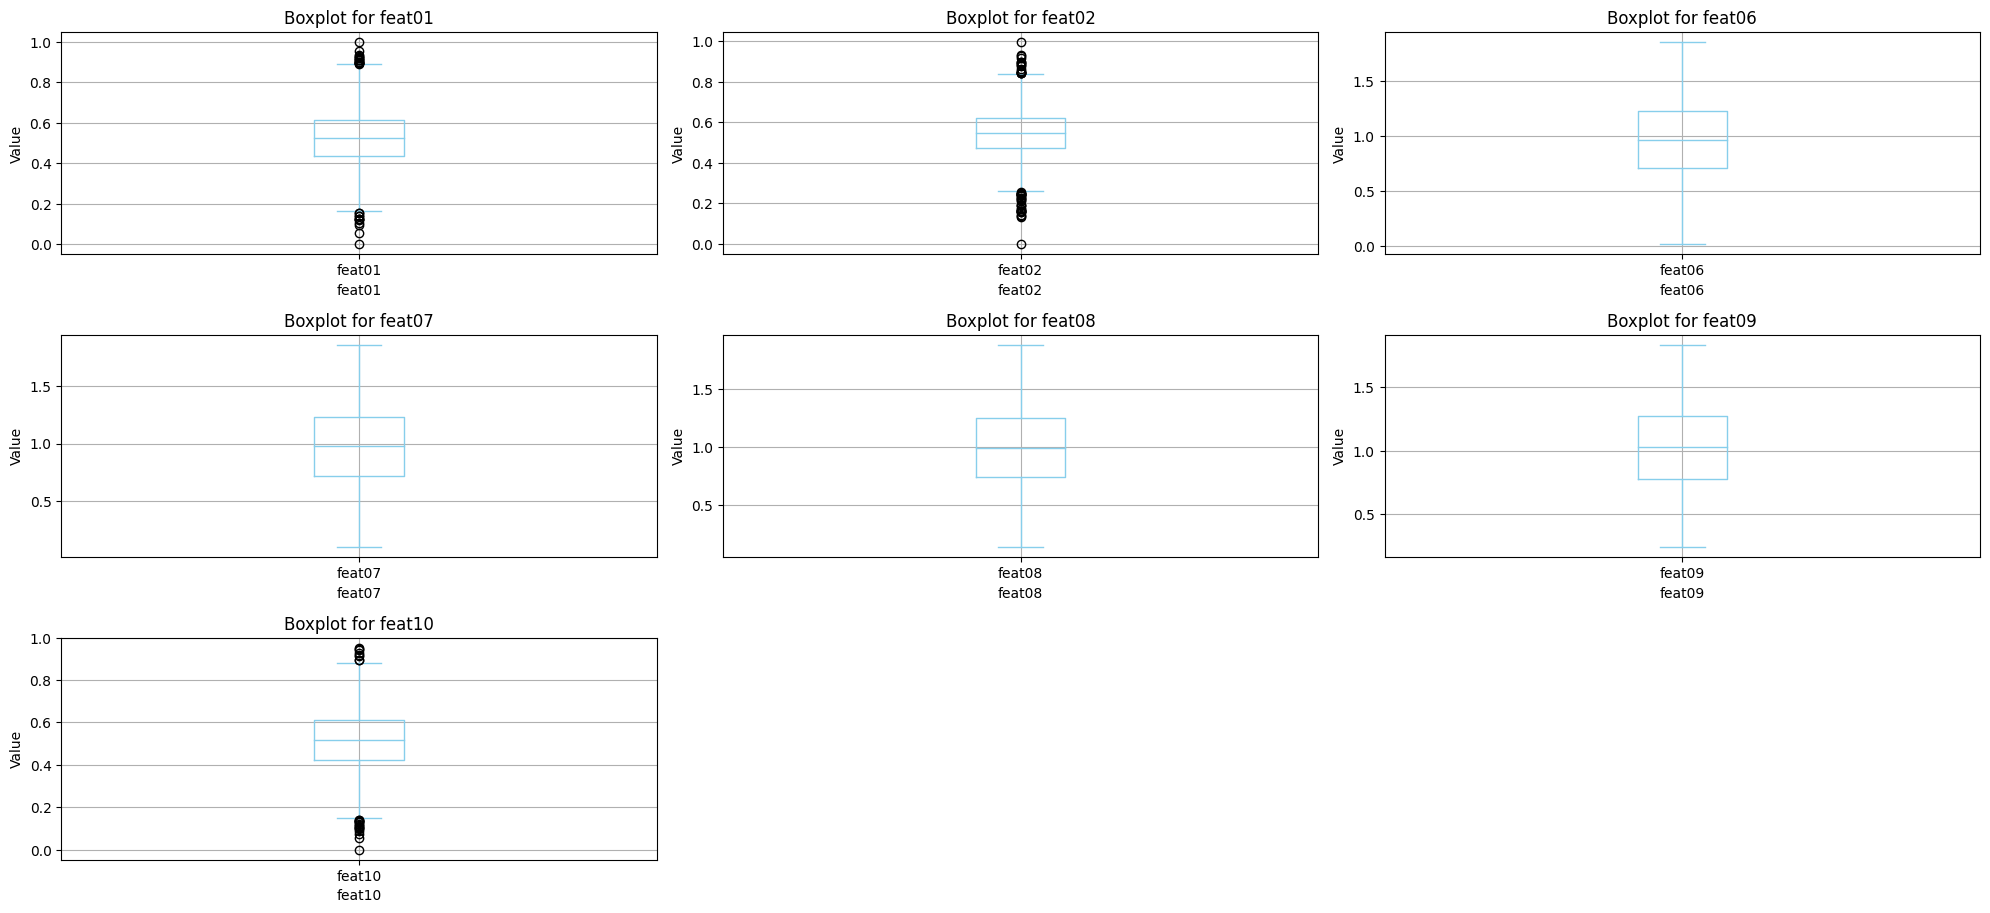

In [41]:
variables_to_plot = [col for col in X_train.columns if X_train[col].nunique() > 2]

# Set up subplots with 2 columns and 7 rows
num_rows = 10
num_columns = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 30))


# Flatten the 2D array of subplots into a 1D array for easy indexing
axes = axes.flatten()

# Plot boxplots for each variable on separate subplots
for i, variable in enumerate(variables_to_plot):
    X_train.boxplot(column=variable, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot for {variable}')
    axes[i].set_xlabel(variable)
    axes[i].set_ylabel('Value')

# Remove any empty subplots if there are fewer variables than total subplots
for j in range(len(variables_to_plot), num_rows * num_columns):
    fig.delaxes(axes[j])

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

(4287, 9)
(1072, 9)
Accuracy: 92.35%


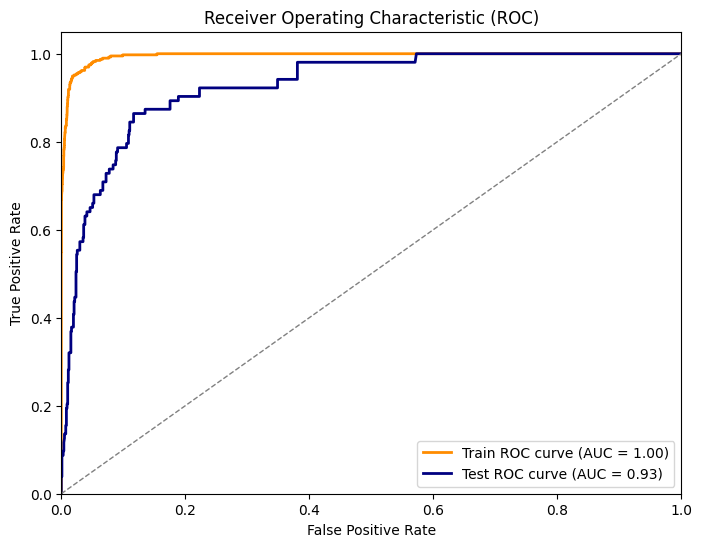

In [96]:
numerical_features = ['feat01', 'feat02',
        'feat04', 'feat06', 'feat07', 'feat08', 'feat09',
       'feat10']
# numerical_features.extend()
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = [ 'Residence_type_Urban', 'ever_married_Yes',
        'smoking_status_never smoked',
       'smoking_status_smokes', 'Residence_type_Urban',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
    #    'gender_Other',
         'age_group_1', 'age_group_2', 'age_group_3',
       'avg_glucose_level_group_1', 'avg_glucose_level_group_2',
       'avg_glucose_level_group_3', 'bmi_group_1', 'bmi_group_2',
       'feat03_group_1', 'feat03_group_2', 'feat03_group_3',
       'feat05_group_1', 'feat05_group_2', 'feat05_group_3', 'heart_disease', 'hypertension']



categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        # ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

selected_feat = ['heart_disease',
 'hypertension',
 'ever_married_Yes',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'Residence_type_Urban',
 'work_type_Never_worked',
 'work_type_children',
 'gender_Male',
 'gender_Other',
 'age_group_1',
 'age_group_2',
 'age_group_3',
 'avg_glucose_level_group_1',
 'avg_glucose_level_group_2',
 'avg_glucose_level_group_3',
 'bmi_group_1',
 'bmi_group_2',
 'bmi_group_3']


selected_feat = ['age',
 'bmi',
 'hypertension',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'work_type_Never_worked',
 'gender_Male',
 'gender_Other']

X_train = X_train[selected_feat]
X_test = X_test[selected_feat]



model = XGBClassifier()
# model.fit(X_train, y_train)

clf = Pipeline(steps=[
    # ('preprocessor', preprocessor),
                      ('classifier', model)])

print(X_train.shape)
print(X_test.shape)

clf.fit(X_train, y_train)


# # model.feature_importances_
# sorted_idx = clf.feature_importances_.argsort()
# plt.figure(figsize=(10,15))
# plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.show()


# fit model no training data


y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = clf.predict_proba(X_train)[:, 1]
y_test_prob = clf.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# model.feature_importances_
# sorted_idx = model.feature_importances_.argsort()
# plt.figure(figsize=(10,15))
# plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.show()

In [78]:
X_train.columns

Index(['feat01', 'feat02', 'feat03', 'feat04', 'feat06', 'feat07', 'feat08',
       'feat09', 'feat10', 'heart_disease', 'hypertension', 'ever_married_Yes',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'Residence_type_Urban',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'gender_Male',
       'gender_Other', 'age_group_1', 'age_group_2', 'age_group_3',
       'avg_glucose_level_group_1', 'avg_glucose_level_group_2',
       'avg_glucose_level_group_3', 'bmi_group_1', 'bmi_group_2',
       'bmi_group_3', 'feat05_group_1', 'feat05_group_2', 'feat05_group_3'],
      dtype='object')

In [16]:
exp = dx.Explainer(clf, X_train, y_train)
imp = exp.model_parts(type = "variable_importance")
# plt.plot(imp)

Preparation of a new explainer is initiated

  -> data              : 4287 rows 34 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4287 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000020EEB821EE0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 5.48e-06, mean = 0.0922, max = 0.995
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.14, mean = -8.76e-05, max = 0.22
  -> model_info        : package sklearn

A new explainer has been created!


In [17]:
imp

,variable,dropout_loss,label
0,Residence_type_Urban,0.000000,XGBClassifier
1,smoking_status_never smoked,0.000000,XGBClassifier
2,hypertension,0.000000,XGBClassifier
3,heart_disease,0.000000,XGBClassifier
4,gender_Male,0.000000,XGBClassifier
5,feat10_group_1,0.000000,XGBClassifier
6,feat05_group_3,0.000000,XGBClassifier
7,feat05_group_2,0.000000,XGBClassifier
8,smoking_status_smokes,0.000000,XGBClassifier
9,ever_married_Yes,0.000000,XGBClassifier


In [94]:
scale_pos_weight = (y_train.shape[0] - y_train.sum()) / y_train.sum()


FFS_LGB_prec_full = SequentialFeatureSelector(
    XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=123),
    k_features=(1,26),
    forward=True,
    verbose=2,
    cv=3,
    scoring = 'roc_auc',
    n_jobs=-1).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   15.1s finished

[2024-01-19 18:53:02] Features: 1/26 -- score: 0.8312838204356127[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.0s finished

[2024-01-19 18:53:03] Features: 2/26 -- score: 0.9012660808751427[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished

[2024-01-19 18:53:04] Features: 3/26 -- score: 0.9061037884903443[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  23 out of  23

In [93]:
# X_train

,age,avg_glucose_level,bmi,feat01,feat02,feat03,feat04,feat05,feat06,feat07,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,Residence_type_Urban,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,gender_Male,gender_Other
3409,13.0,63.22,18.5,0.570176,0.606486,0.521926,1.368079,0.705436,0.574529,0.480470,...,True,False,False,True,False,False,False,True,False,False
1228,78.0,224.15,NaN,0.660515,0.359121,0.594148,1.152842,0.769563,0.990169,1.079975,...,False,False,False,True,False,True,False,False,True,False
1116,40.0,104.64,24.9,0.421662,0.537413,0.450923,1.466377,0.757969,1.265348,0.832882,...,False,False,False,True,False,True,False,False,True,False
1014,49.0,67.68,24.8,0.602786,0.611396,0.844011,0.491453,0.723060,0.591935,1.372342,...,True,False,False,True,False,True,False,False,False,False
3834,40.0,153.24,38.2,0.667395,0.611071,0.570149,0.705432,1.493823,0.760872,1.442572,...,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,5.0,104.55,16.3,0.547479,0.540067,1.226619,0.761907,0.939234,0.924596,1.301093,...,False,False,False,False,False,False,False,True,True,False
2715,51.0,86.25,29.0,0.388300,0.766376,1.409998,0.636542,0.632279,0.744006,1.463443,...,False,True,False,True,False,False,False,False,False,False
2204,59.0,60.64,20.0,0.649106,0.562244,0.625305,1.226736,0.847527,0.689423,0.806393,...,False,True,False,False,False,True,False,False,False,False
2693,12.0,70.07,24.5,0.357520,0.414479,1.468133,0.916039,1.162535,0.775409,1.332973,...,True,False,False,True,False,False,False,True,True,False


In [95]:
# list(FFS_LGB_prec_full.k_feature_names_)
# len(list(FFS_LGB_prec_full.k_feature_names_))

selected_features_full_xgb = list(FFS_LGB_prec_full.k_feature_names_)
selected_features_full_xgb

['age',
 'bmi',
 'hypertension',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'work_type_Never_worked',
 'gender_Male',
 'gender_Other']

In [70]:
selected_features_full_xgb

['feat01',
 'feat02',
 'feat03',
 'feat06',
 'feat08',
 'feat09',
 'feat10',
 'heart_disease',
 'hypertension',
 'ever_married_Yes',
 'smoking_status_smokes',
 'Residence_type_Urban',
 'work_type_Never_worked',
 'gender_Male',
 'gender_Other',
 'age_group_1',
 'age_group_3',
 'avg_glucose_level_group_1',
 'avg_glucose_level_group_2',
 'avg_glucose_level_group_3',
 'bmi_group_1',
 'bmi_group_2',
 'bmi_group_3',
 'feat05_group_1',
 'feat05_group_2']

In [65]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [61]:
mp = exp.model_performance(model_type = 'classification')
mp.result

,recall,precision,f1,accuracy,auc
XGBClassifier,1.0,1.0,1.0,1.0,1.0


In [62]:
# print(mp.result.auc[0])
# mp.plot(geom="roc")

In [97]:
vi = exp.model_parts()
# pd.options.display.float_format = '{:.3f}'.format
# vi.result

# exp = dx.Explainer(model, X_train, y_train)
# y_test_pred = exp.predict_parts(X_test[0], type='break_down')

# vi = exp.model_parts()
# vi.result
pdp_num = exp.model_profile(type = 'partial', label="pdp")
ale_num = exp.model_profile(type = 'accumulated', label="ale")
pdp_num.plot(ale_num)

Calculating accumulated dependency: 100%|██████████| 8/8 [00:00<00:00, 13.27it/s]


In [64]:
# aaaaaaaaaaaaaaaa

NameError: name 'aaaaaaaaaaaaaaaa' is not defined

### MLP

In [98]:
classifier = MLPClassifier(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = classifier.predict_proba(X_train)[:, 1]
y_test_prob = classifier.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

ValueError: Input X contains NaN.
MLPClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Accuracy: 92.63%


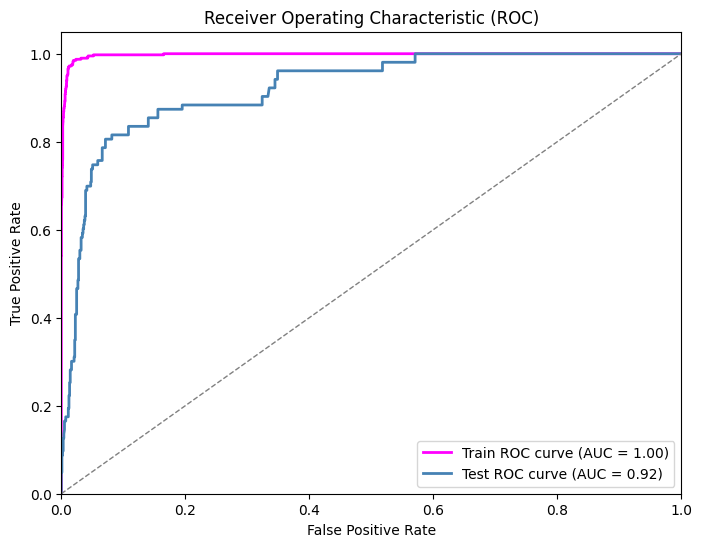

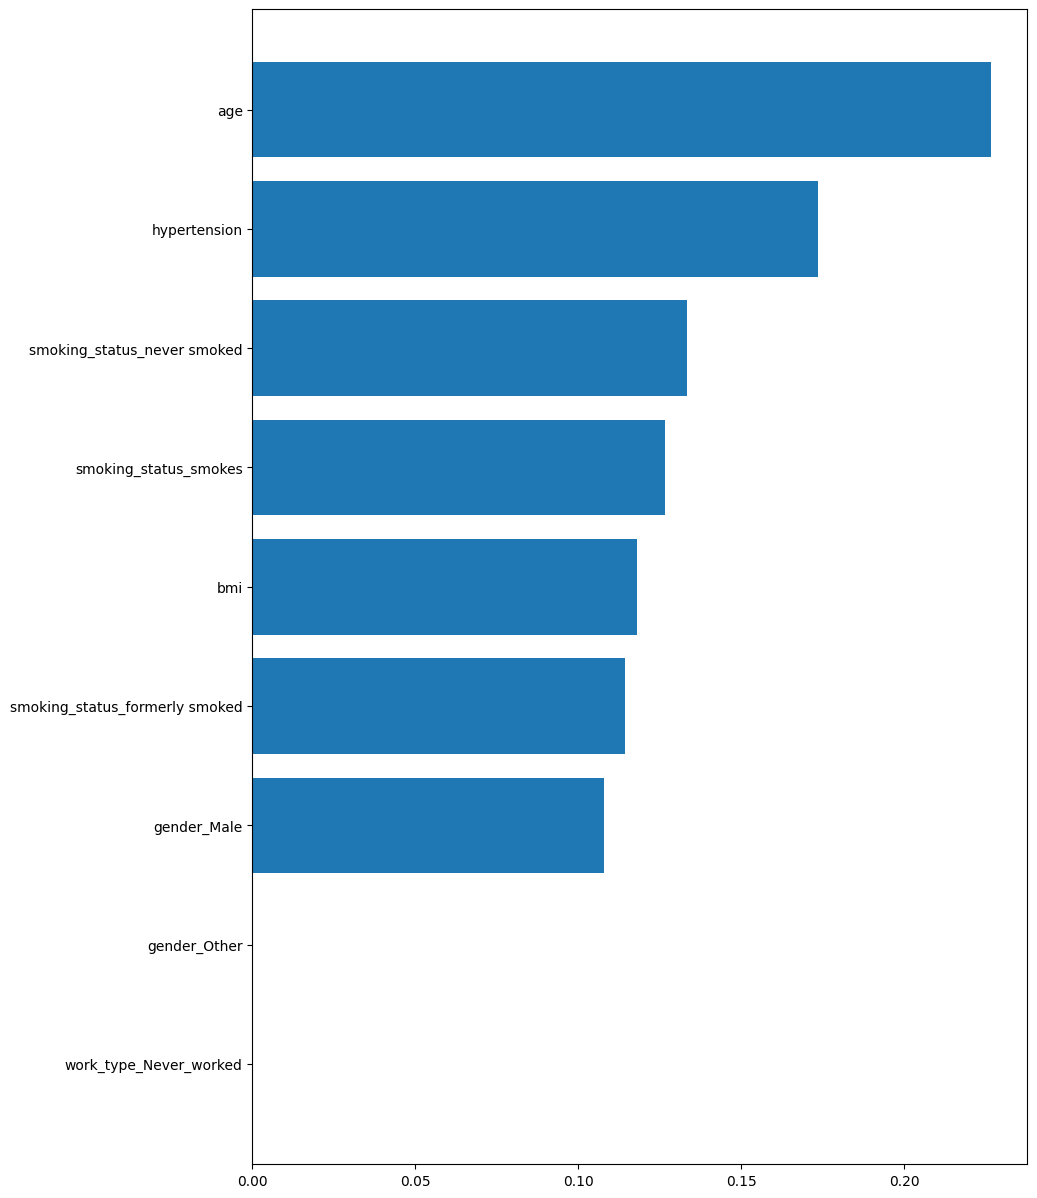

In [100]:
# fit model no training data
model = XGBClassifier(learning_rate = 0.3, n_estimators = 400, max_depth = 10, min_child_weight = 8)#, scale_pos_weight = 0.07)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='fuchsia', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='steelblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
# model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()

### Feature selection

In [ ]:
# train_selected, drop_lst= toad.selection.select(frame = X_train,
#                                                 target=y_train,  
#                                                 iv = 0.03, corr = 0.6, 
#                                                 return_drop=True 
#                                                 )
# print("keep:",train_selected.shape[1],
#       "drop empty:",len(drop_lst['empty']),
#       "drop iv:",len(drop_lst['iv']),
#       "drop corr:",len(drop_lst['corr']))

# def output_iv_importance(train_selected,label_col):
#     feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
#     feat_import_iv=feat_import_iv['iv']
#     feat_import_iv = feat_import_iv.reset_index()
#     feat_import_iv.columns = ['name','iv']
#     return feat_import_iv
# df_iv=output_iv_importance(train_selected, y_train)
# df_iv = df_iv[df_iv['iv'] < 0.95]
# df_iv.shape



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

X_train = X_train[X_train.columns[sorted_idx][0:14]]
X_test = X_test[X_test.columns[sorted_idx][0:14]]

# df_iv

IndexError: index 29 is out of bounds for axis 0 with size 26

Accuracy: 92.35%


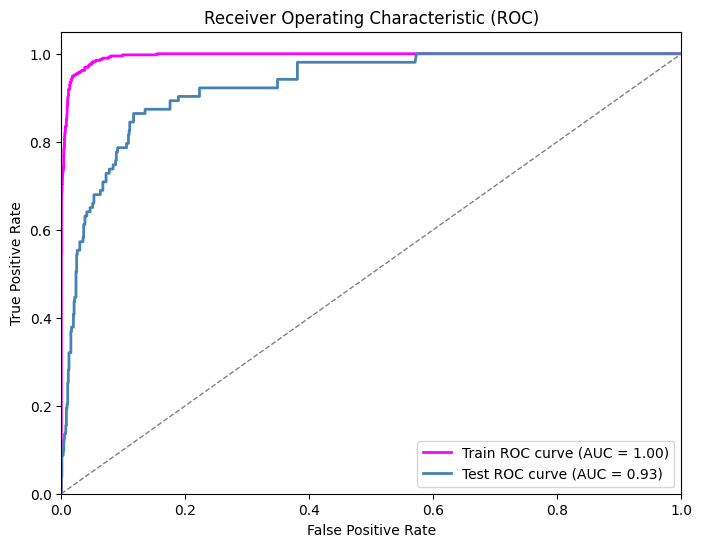

In [101]:
# fit model no training data
model = XGBClassifier()#learning_rate = 0.3, n_estimators = 400, max_depth = 10, min_child_weight = 8, scale_pos_weight = 0.07)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# 3. Get predicted probabilities for both training and testing data
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

# 4. Compute ROC curves and AUC for both datasets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot both ROC curves on one graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='fuchsia', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='steelblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

<BarContainer object of 26 artists>

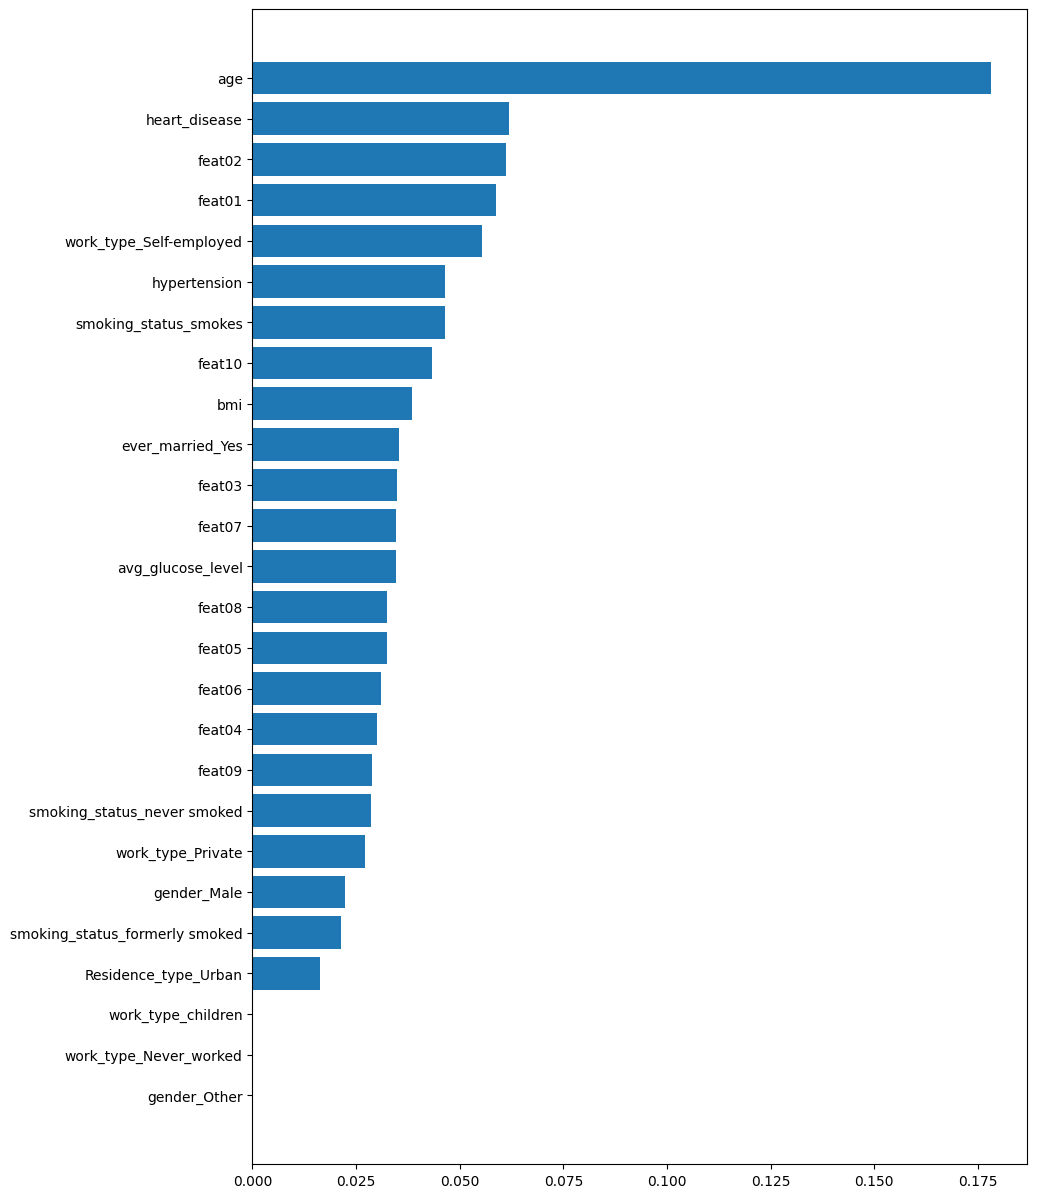

In [ ]:
# model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score

X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']


numerical_features = ['age', 'avg_glucose_level', 'bmi', 'feat01', 'feat02',
       'feat03', 'feat04', 'feat05', 'feat06', 'feat07', 'feat08', 'feat09',
       'feat10', 'heart_disease', 'hypertension']
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_features = [ 'Residence_type', 'smoking_status', 'work_type', 'ever_married']
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

classifier = MLPClassifier(random_state=0, max_iter = 500, learning_rate = 0.01, hidden_layer_sizes = (100, 100, 100))

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies_test = []
accuracies_train = []

for train_index, test_index in stratified_kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc_train = balanced_accuracy_score(y_train, clf.predict(X_train))
    acc_test = balanced_accuracy_score(y_test, y_pred)
    accuracies_test.append(acc_test)
    accuracies_train.append(acc_train)



# Calculate the mean AUC score from cross-validation
mean_accuracy_train = np.mean(accuracies_train)
mean_accuracy_test = np.mean(accuracies_test)


print('train:', accuracies_train, 'test:', accuracies_test)


KeyError: "['id'] not found in axis"

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the range of hyperparameters
param_dist = {
    'classifier__hidden_layer_sizes': [(50, ), (100, ), (150, ), (50, 50), (100, 100), (150, 150)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
    'classifier__max_iter': randint(200, 1000),  # Range from 200 to 1000
    'classifier__early_stopping': [True, False],
    'classifier__validation_fraction': [0.1, 0.2, 0.3]
}

# Create an MLPClassifier
classifier = MLPClassifier(random_state=0)

# Use the pipeline and include the classifier inside the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, cv=stratified_kf, scoring='balanced_accuracy', verbose=1, n_jobs=-1, random_state=42)

# Fit the random search to find the best hyperparameters
random_search.fit(X, y)

# Get the best hyperparameters
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Balanced Accuracy:", best_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.01, 'classifier__early_stopping': False, 'classifier__hidden_layer_sizes': (150,), 'classifier__learning_rate': 'constant', 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 493, 'classifier__solver': 'sgd', 'classifier__validation_fraction': 0.1}
Best Balanced Accuracy: 0.6728957370899817
